In [1]:
from glob import glob
import json
import os
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import subsample_lfp, remove_lfp_offset
# from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib widget

#### Plot electrodes

### Load experiment

In [6]:
recfolder = r'E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_estim_2023-07-13_13-28-01\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [7]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load EEG data

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [9]:
print(eeg_ts[0])
print(eeg_ts[-1])

79.3536544827942
6682.103505585035


In [10]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

### Load SWDs

In [11]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is


In [49]:
autoSWD_df.tail()

,onset,offset,duration,spike_count,SWD_spike_times
702,6590.456045,6590.968041,0.511996,3,"[6590.456045377252, 6590.616044137182, 6590.96..."
703,6626.925094,6627.479904,0.554810,3,"[6626.925093530285, 6627.278300031907, 6627.47..."
704,6640.770864,6641.321260,0.550396,4,"[6640.770864388039, 6640.944862983272, 6641.12..."
705,6646.320020,6647.196013,0.875993,4,"[6646.32001958729, 6646.5236179435515, 6646.83..."
706,6668.508640,6669.034242,0.525602,3,"[6668.508640448879, 6668.86344144935, 6669.034..."


In [52]:
autoSWD_df[250:260]

,onset,offset,duration,spike_count,SWD_spike_times
250,2633.329650,2633.831257,0.501607,4,"[2633.3296496987628, 2633.487651841786, 2633.6..."
251,2645.405751,2645.956145,0.550394,3,"[2645.405751294306, 2645.7605471695774, 2645.9..."
252,2652.801665,2653.516457,0.714792,4,"[2652.8016653120803, 2652.9952630613825, 2653...."
253,2655.618433,2656.210426,0.591993,4,"[2655.618432565361, 2655.7388311656505, 2656.0..."
254,2673.229428,2674.174617,0.945189,4,"[2673.229427826289, 2673.587023669009, 2673.78..."
255,2676.342996,2676.870590,0.527595,3,"[2676.3429955695206, 2676.6877921177793, 2676...."
256,2680.533354,2681.262946,0.729593,5,"[2680.533353620053, 2680.684952102408, 2680.98..."
257,2684.864510,2686.203697,1.339187,6,"[2684.864510261057, 2685.057708326961, 2685.24..."
258,2700.213157,2700.869950,0.656793,3,"[2700.2131566065154, 2700.5127536072646, 2700...."
259,2702.822330,2704.277116,1.454785,6,"[2702.8223304862045, 2703.189926806216, 2703.5..."


Print some stats

In [13]:
print('Number of SWDs in {:d} min recording: {:d} events'.format(int((eeg_ts[-1]-eeg_ts[0])/60), len(autoSWD_df)))
print('Average SWD duration: {:.1f} s [min={:.1f}, max={:.1f}]'.format(
    np.mean(autoSWD_df['duration'].values), np.min(autoSWD_df['duration'].values), np.max(autoSWD_df['duration'].values)))
print('Total time spent in SWD: {:.1f} min'.format(np.sum(autoSWD_df['duration'].values)/60))

Number of SWDs in 110 min recording: 707 events
Average SWD duration: 0.8 s [min=0.5, max=2.2]
Total time spent in SWD: 9.0 min


### Load units and spikes

In [14]:
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,other-TH
1,B4,probeB,1,3640,0.508208,AMv,253,179,195,other-TH
2,B9,probeB,3,3620,0.590620,AMv,253,178,195,other-TH
3,B10,probeB,4,3600,0.480737,AMv,253,177,194,other-TH
4,B11,probeB,5,3600,0.480737,AMv,253,177,194,other-TH


In [15]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

HIP: 113 units
MO: 73 units
PAL: 69 units
RT-TH: 12 units
SM-TH: 59 units
SS: 135 units
STR: 97 units
VIS: 24 units
other-TH: 208 units


### Load LFP

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeD', 'probeF']


In [ ]:
LFP_traces = {}
for pbi, probei in enumerate(probe_list):

In [17]:
probei = 'probeD'

lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
lfp_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')

In [18]:
print(lfp_ts.shape)
print(lfp_mm.shape)

(16506874,)
(16506874, 384)


In [19]:
with open(exp.ephys_params[probei]['probe_info']) as data_file:
    data = json.load(data_file)
    
## Get info ##
npx_allch = np.array(data['channel']) # this is an array from 0 to 384
surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"

print(surface_ch)
print(air_ch)

370
384


In [20]:
allch_areas = np.array(data['area_ch'])
print(np.unique(allch_areas))

['CP' 'RT' 'SSp-bfd1' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a'
 'SSp-bfd6b' 'VAL' 'VL' 'VPL' 'ccb' 'em' 'fi' 'fiber tracts' 'null' 'or'
 'st']


In [30]:
ROI = 'SSp'
ROImask = [True if ROI in x else False for x in allch_areas]
print(np.sum(ROImask))

125


Testing

In [23]:
SWDind = 40
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.0

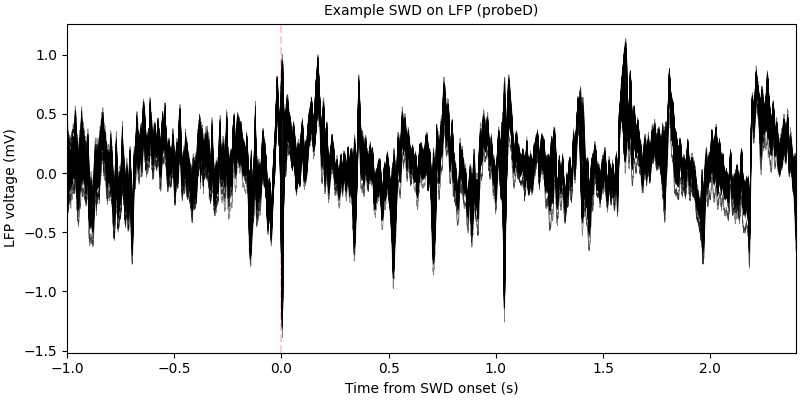

In [26]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
# ax.plot(lfp_ts[tsinds] - timezero, saline_ref[tsinds] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='m', linewidth=1.0, alpha=0.8)
ax.set_xlim(pwin - timezero)
ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP voltage (mV)')
ax.set_title('Example SWD on LFP ({})'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Plot an SWD event

In [32]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'VIS', 'SS', 'MO']

In [53]:
SWDind = 257
SWDevent = autoSWD_df.iloc[SWDind]
print(SWDevent.duration)

1.339186593469094


In [59]:
deltat = 1.0 # time around SWD to plot, s

Plot EEG + LFP + all region raster

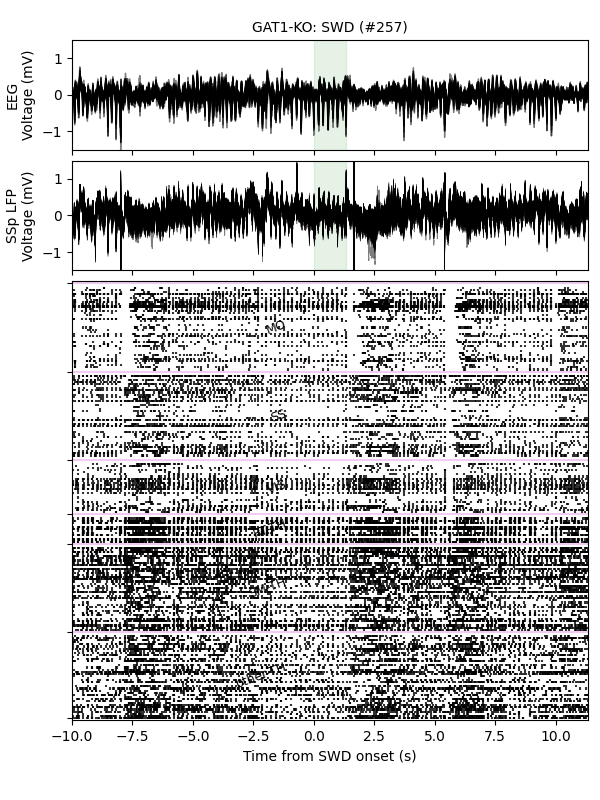

In [60]:
## Plot one half-slide ##
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
umax = 40

fig = plt.figure(figsize=(6, 8)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=3, left=0.12, right=0.98, top=0.95, bottom=0.1, hspace=0.05, height_ratios=[1, 1, 4])
EEGax = fig.add_subplot(gs[0])
LFPax = fig.add_subplot(gs[1])
rasterax = fig.add_subplot(gs[2])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > pwin[0]) & (eeg_ts < pwin[1]))[0]
EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(pwin - timezero)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1.5, 1.5])
# EEGax.set_ylim([-0.25, 0.25])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('GAT1-KO: SWD (#{:d})'.format(SWDind))
# EEGax.set_title('Wild type (not litter mate): spontaneous activity')

## Plot LFP ##
tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
LFPax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
LFPax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
LFPax.set_xlim(pwin - timezero)
LFPax.set_xticklabels([])
LFPax.set_ylim([-1.5, 1.5])
LFPax.set_ylabel('{} LFP\nVoltage (mV)'.format(ROI))

## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwin[0]) & (uspiketimes < pwin[1]))[0]
        ]
        rasterax.eventplot(SWDspikes - timezero, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(-1.05, last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwin - timezero)
rasterax.set_xlabel('Time from SWD onset (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = 'SWD_EEG_LFP_NPX_example{:d}.png'.format(SWDind)
# fig_name = 'spont_EEG_NPX_example.png'
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Plot ALL region raster

### Plot multiple SWD events

In [22]:
len(autoSWD_df)

829

In [25]:
autoSWD_df[(autoSWD_df['duration'] > 1.8) & (autoSWD_df['duration'] < 2.2)][:10]

,onset,offset,duration,spike_count,SWD_spike_times
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
21,196.202070,198.354060,2.151990,13,"[196.20206980036556, 196.33886915980443, 196.4..."
34,251.572628,253.498624,1.925996,14,"[251.57262780484655, 251.9530270677896, 252.10..."
35,254.475422,256.303019,1.827596,13,"[254.4754221804278, 254.61662190684095, 254.75..."
45,300.105219,302.073239,1.968020,13,"[300.1052188619777, 300.2220200312601, 300.348..."
47,306.862087,308.998882,2.136796,13,"[306.86208650416586, 307.0236881219402, 307.20..."
105,635.813841,637.819856,2.006015,14,"[635.8138406935439, 635.9538417334074, 636.243..."
130,745.071978,747.047959,1.975981,14,"[745.0719779810114, 745.2023767176904, 745.333..."
133,754.566686,756.618666,2.051980,13,"[754.5666859949622, 754.6914847858942, 754.993..."
134,758.479048,760.335030,1.855982,15,"[758.4790480914552, 758.5934469831428, 758.733..."


In [28]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'SS']
deltat = 0.5 # time around SWD to plot, s
SWDinds = [1, 34, 35, 45, 47]

<IPython.core.display.Javascript object>


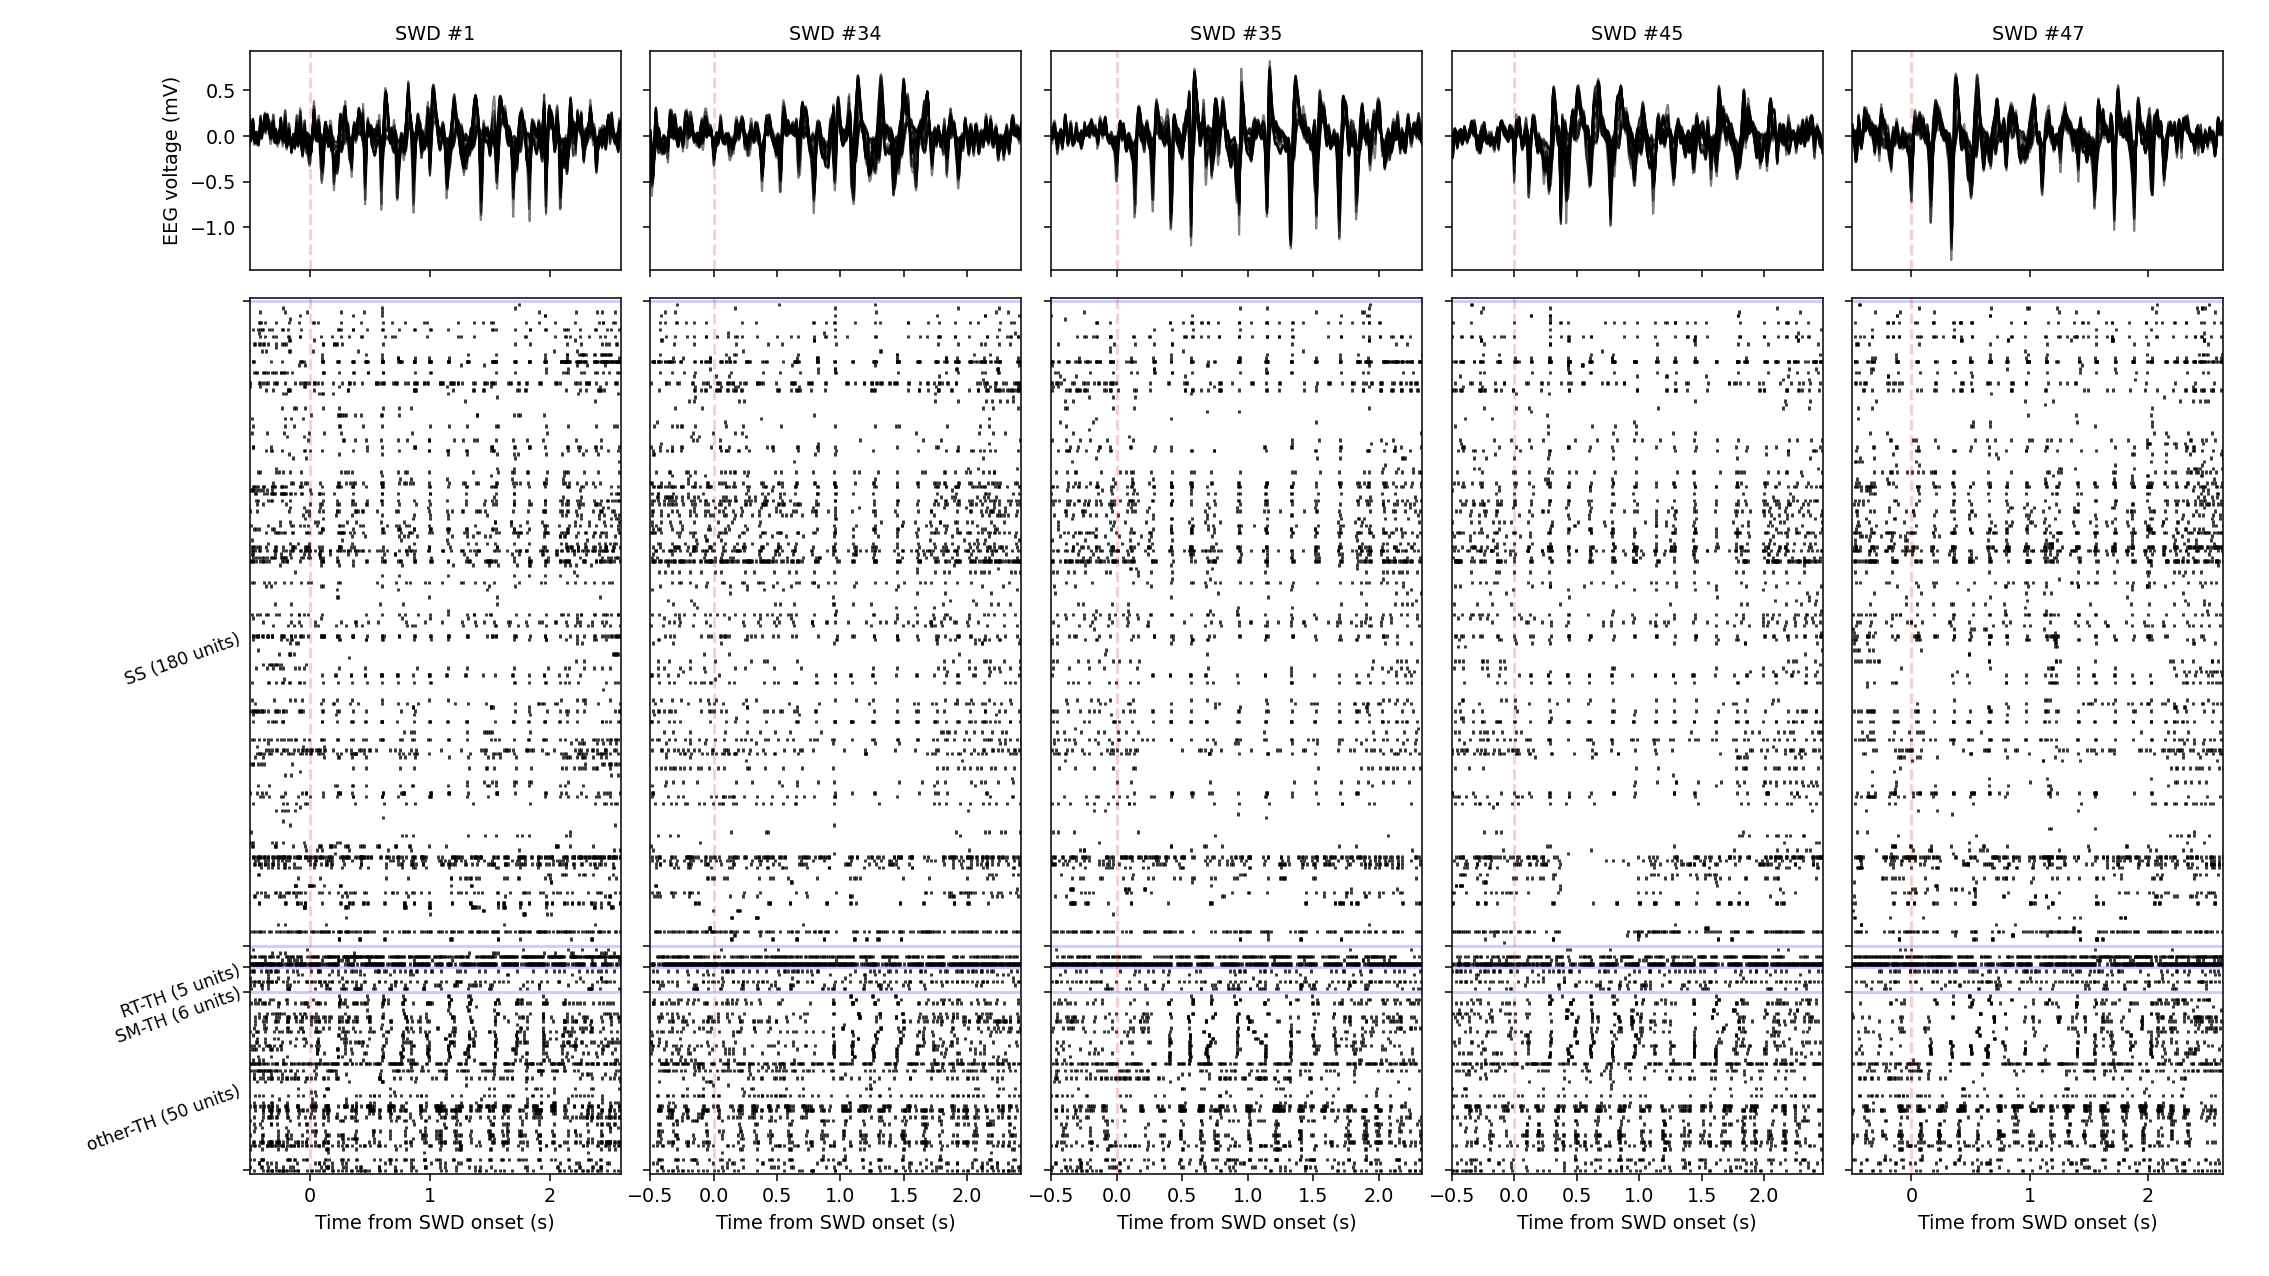

In [29]:
fig = plt.figure(figsize=(12, 6.75)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.11, right=0.98, top=0.96, bottom=0.08, hspace=0.05, height_ratios=[1,4])
EEGaxs = gs[0].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)
rasteraxs = gs[1].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)

for coli, SWDind in enumerate(SWDinds):
    SWDevent = autoSWD_df.iloc[SWDind]
    timezero = SWDevent.onset
    plotwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
    
    ## Plot EEG ##
    eeginds = np.nonzero((eeg_ts > plotwin[0]) & (eeg_ts < plotwin[1]))[0]
    EEGaxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    EEGaxs[coli].plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
    EEGaxs[coli].set_xlim(plotwin - timezero)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_title('SWD #{:d}'.format(SWDind))
    
    ## Plot raster ##
    rasteraxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    last_ind = 0
    regb = [last_ind]
    for ii, pregi in enumerate(plot_regions):
        regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
        for indi, urow in regdf.iterrows():
            uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
            SWDspikes = uspiketimes[
                np.nonzero((uspiketimes > plotwin[0]) & (uspiketimes < plotwin[1]))[0]
            ]
            rasteraxs[coli].eventplot(SWDspikes - timezero, lineoffsets=indi + last_ind, linelengths=1.0, color='black', alpha=0.8)
        if coli == 0:
            rasteraxs[coli].annotate(
                '{} ({:d} units)'.format(pregi, len(regdf)), xy=(-0.55, last_ind + indi/2 - 10), xycoords='data',
                annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
            )
        last_ind += indi + 2
        regb.append(last_ind - 1)
        rasteraxs[coli].axhline(last_ind - 1, color='b', alpha=0.2)

    rasteraxs[coli].set_ylim(-1, last_ind)
    rasteraxs[coli].set_xlim(plotwin - timezero)
    rasteraxs[coli].set_xlabel('Time from SWD onset (s)')
    rasteraxs[coli].set_yticks(regb)
    rasteraxs[coli].set_yticklabels([])

EEGaxs[0].set_ylabel('EEG voltage (mV)')

### SAVE ###
fig_name = 'multiSWD_EEG_NPX_example.png'
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

## LFP re-reference comparison
<br>SLC6A1 recordings in 2023 were done with external ref and 3 CB screws, so it shouldn't be necessary.

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeD', 'probeF']


In [ ]:
LFP_traces = {}
for pbi, probei in enumerate(probe_list):

In [41]:
probei = 'probeD'

lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
lfp_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')

In [31]:
print(lfp_ts.shape)
print(lfp_mm.shape)

(16506939,)
(16506939, 384)


In [42]:
with open(exp.ephys_params[probei]['probe_info']) as data_file:
    data = json.load(data_file)
    
## Get info ##
npx_allch = np.array(data['channel']) # this is an array from 0 to 384
surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"

print(surface_ch)
print(air_ch)

370
384


In [43]:
## Get all ch depths ##
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
## Get saline chs for re-ref ##
if air_ch - 10 > surface_ch:
    saline_chs = np.arange(air_ch - 10, air_ch)
else:
    saline_chs = np.arange(surface_ch + 1, air_ch)

print(saline_chs)

[374 375 376 377 378 379 380 381 382 383]


In [44]:
saline_ref = np.median(lfp_mm[:, saline_chs], axis=1)

In [45]:
reref_lfp = lfp_mm - saline_ref[:, None]

Testing

In [36]:
SWDind = 40
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.0

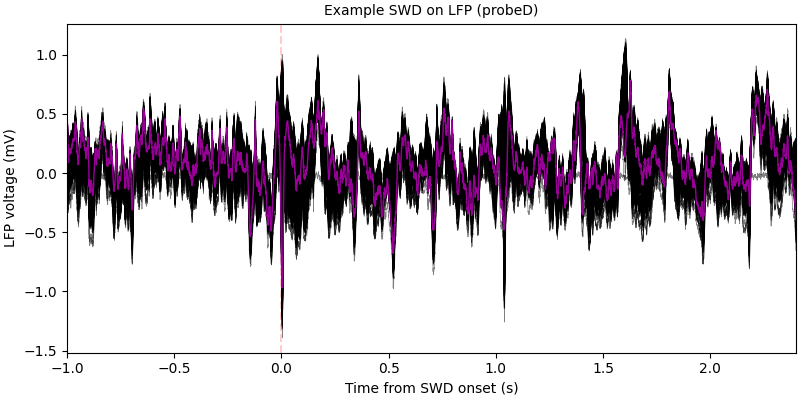

In [46]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
ax.plot(lfp_ts[tsinds] - timezero, saline_ref[tsinds] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='m', linewidth=1.0, alpha=0.8)
ax.set_xlim(pwin - timezero)
ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP voltage (mV)')
ax.set_title('Example SWD on LFP ({})'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

In [ ]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax.plot(lfp_ts[tsinds] - timezero, reref_lfp[tsinds, :] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
ax.set_xlim(pwin - timezero)
ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP voltage (mV)')
ax.set_title('Example SWD on LFP ({}) saline ref'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

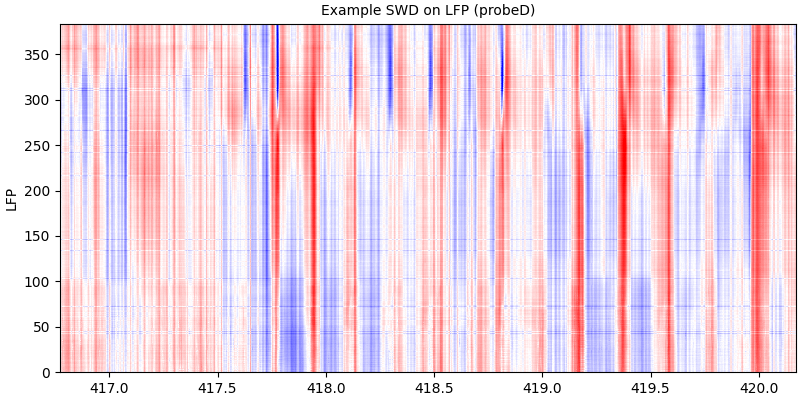

In [48]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)

ax.imshow(
    lfp_mm[tsinds, :].T * exp.ephys_params[probei]['bit_volts'] * 1e-3,
    origin='lower', aspect='auto', cmap='bwr', vmin=-1, vmax=1, interpolation='none',
    extent=[lfp_ts[tsinds][0], lfp_ts[tsinds][-1], 0, lfp_mm.shape[1]]
)

# ax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :], color='k', linewidth=0.5, alpha=0.5)
# ax.set_xlim(pwin - timezero)
# ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP')
ax.set_title('Example SWD on LFP ({})'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

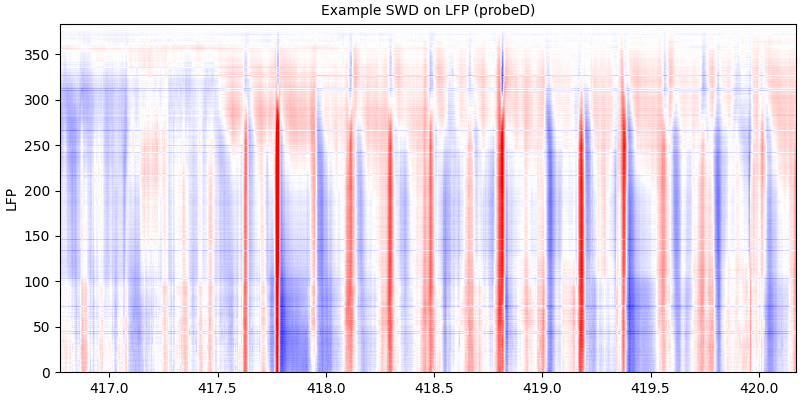

In [49]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)

ax.imshow(
    reref_lfp[tsinds, :].T * exp.ephys_params[probei]['bit_volts'] * 1e-3,
    origin='lower', aspect='auto', cmap='bwr', vmin=-1, vmax=1, interpolation='none',
    extent=[lfp_ts[tsinds][0], lfp_ts[tsinds][-1], 0, reref_lfp.shape[1]]
)

# ax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :], color='k', linewidth=0.5, alpha=0.5)
# ax.set_xlim(pwin - timezero)
# ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP')
ax.set_title('Example SWD on LFP ({})'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)